In [1]:
# The standard workflow: compile(), fit(), evaluate(), predict()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
  inputs = keras.Input(shape = (28*28, ))
  features = layers.Dense(512, activation = "relu")(inputs)
  features = layers.Dropout(0.5)(features)
  outputs = layers.Dense(10, activation = "softmax")(features)

  model = keras.Model(inputs, outputs)
  return model


In [3]:
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28*28)).astype("float32") / 255

train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()

model.compile(optimizer = "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

model.fit(train_images, train_labels, epochs = 3, validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)
print(f'\n {test_metrics}')
predictions = model.predict(test_images)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8680 - loss: 0.4430 - val_accuracy: 0.9596 - val_loss: 0.1423
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9516 - loss: 0.1667 - val_accuracy: 0.9659 - val_loss: 0.1154
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9628 - loss: 0.1277 - val_accuracy: 0.9717 - val_loss: 0.1061
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9685 - loss: 0.1114

 [0.09697431325912476, 0.9728999733924866]
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [4]:
# 1. writing own metrics

class RootMeanSquaredError(keras.metrics.Metric):
  # define the state variables in the constructor
  def __init__(self, name = "rmse", **kwargs):
    super().__init__(name = name, **kwargs)
    self.mse_sum = self.add_weight(name = "mse_sum", initializer = "zeros")
    self.total_samples = self.add_weight(name = "total_samples", initializer = "zeros", dtype = "int32")

  def update_state(self, y_true, y_pred, sample_weight = None):
    y_true = tf.one_hot(y_true, depth = tf.shape(y_pred)[1])
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    self.mse_sum.assign_add(mse)
    num_samples = tf.shape(y_pred)[0]
    self.total_samples.assign_add(num_samples)

  def result(self):
    return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

  def reset_state(self):
    self.mse_sum.assign(0.)
    self.total_samples.assign(0)

model = get_mnist_model()
model.compile(optimizer = "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy", RootMeanSquaredError()])

model.fit(train_images, train_labels,
          epochs = 3,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8670 - loss: 0.4452 - rmse: 0.0244 - val_accuracy: 0.9592 - val_loss: 0.1473 - val_rmse: 0.0141
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9525 - loss: 0.1646 - rmse: 0.0151 - val_accuracy: 0.9662 - val_loss: 0.1220 - val_rmse: 0.0127
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9629 - loss: 0.1275 - rmse: 0.0133 - val_accuracy: 0.9718 - val_loss: 0.0981 - val_rmse: 0.0115
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9694 - loss: 0.1106 - rmse: 0.0120


In [5]:
# 2. using callbacks
"""
(a) Model checkpointing: save the current state of the model at different points during training
(b) Early stopping: interrupting the training when the validation loss is no longer improving (saving best model during training)
(c) Dynamically adjusting the value of certain parameters during training: such as learning rate of the optimizer
(d) Logging training and validation metrics during training or visualizing the representations learned by the model as they're updated: fit() progress bar

keras.callbacks

keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger
"""
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        # interrupts training when validation accuracy has stopped imporving for 2 epochs
        patience = 2,
    ),

    # saves the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        filepath = "checkpoint_path.keras",
        # won't overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training
        monitor = "val_loss",
        save_best_only = True,
    )
]

model = get_mnist_model()
model.compile(optimizer = "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

model.fit(train_images, train_labels,
          epochs = 10,
          callbacks = callbacks_list,
          validation_data = (val_images, val_labels))

# reload
model = keras.models.load_model("checkpoint_path.keras")

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8633 - loss: 0.4536 - val_accuracy: 0.9562 - val_loss: 0.1529
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9510 - loss: 0.1747 - val_accuracy: 0.9682 - val_loss: 0.1155
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9614 - loss: 0.1322 - val_accuracy: 0.9727 - val_loss: 0.0984
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9660 - loss: 0.1211 - val_accuracy: 0.9740 - val_loss: 0.0981
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9711 - loss: 0.0992 - val_accuracy: 0.9772 - val_loss: 0.0868
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9747 - loss: 0.0920 - val_accuracy: 0.9737 - val_loss: 0.1020
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9766 - loss: 0.0825 - val_accuracy: 0.9797 - val_loss: 0.0846
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9783 - loss:

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8691 - loss: 0.4424 - val_accuracy: 0.9580 - val_loss: 0.1431
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9528 - loss: 0.1613 - val_accuracy: 0.9693 - val_loss: 0.1128
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9622 - loss: 0.1310 - val_accuracy: 0.9719 - val_loss: 0.1097
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9687 - loss: 0.1118 - val_accuracy: 0.9745 - val_loss: 0.1008
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9714 - loss: 0.0998 - val_accuracy: 0.9758 - val_loss: 0.0946
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9749 - loss: 0.0886 - val_accuracy: 0.9791 - val_loss: 0.0914
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9761 - loss: 0.0845 - val_accuracy: 0.9792 - val_loss: 0.0876
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9779 - loss: 0

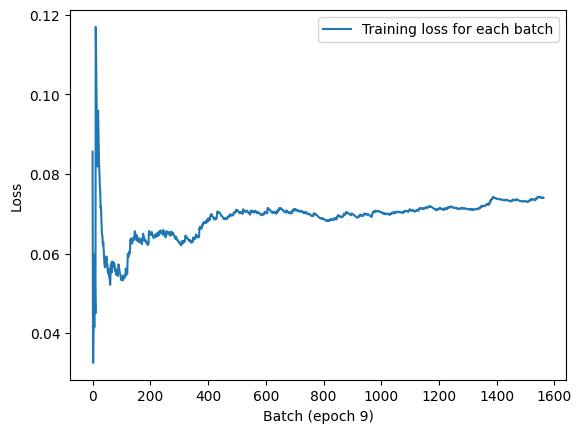

In [8]:
# 3. writing own callbacks
from matplotlib import pyplot as plt
# stores loss after every batch

class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs):
    self.per_batch_losses = []

  def on_batch_end(self, batch, logs):
    self.per_batch_losses.append(logs.get("loss"))

  def on_epoch_end(self, epoch, logs):
    plt.clf()
    plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses, label = "Training loss for each batch")
    plt.xlabel(f"Batch (epoch {epoch})")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"plot_at_epoch_{epoch}")
    self.per_batch_losses = []


model = get_mnist_model()
model.compile(optimizer = "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])
model.fit(train_images, train_labels,
          epochs = 10,
          callbacks = [LossHistory()],
          validation_data = (val_images, val_labels))

In [9]:
# 4. monitorting and visualization with TensorBoard
model = get_mnist_model()
model.compile(optimizer = "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])



import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard = keras.callbacks.TensorBoard(
    log_dir = "/full_path_to_your_log_dir",histogram_freq=1

)
model.fit(train_images, train_labels,
          epochs = 10,
          callbacks = [tensorboard],
          validation_data = (val_images, val_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8673 - loss: 0.4416 - val_accuracy: 0.9610 - val_loss: 0.1393
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9530 - loss: 0.1615 - val_accuracy: 0.9677 - val_loss: 0.1233
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9631 - loss: 0.1332 - val_accuracy: 0.9730 - val_loss: 0.1065
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9690 - loss: 0.1115 - val_accuracy: 0.9743 - val_loss: 0.0984
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9721 - loss: 0.1013 - val_accuracy: 0.9762 - val_loss: 0.0879
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9748 - loss: 0.0889 - val_accuracy: 0.9792 - val_loss: 0.0857
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9769 - loss: 0.0807 - val_accuracy: 0.9791 - val_loss: 0.0896
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9776 - loss: 0